# House Prices - Advanced Regression Techniques

#### This colab notebook contains the code for approaching the famous basic Kaggle contest "House Prices - Advanced Regression Techniques".

I will approach the problem with following basic phases.


1.   Downloading the data
2.   Splitting the data
3.   EDA, Data Visualization and Feature Engineering
4.   Basic Linear Regression model
5.   Using bigger DL models
6.   Hyperparameter Tuning
7.   Finetuning the model
8.   Model evaluation on test data
9.  Submission 🎉🥳



## Downloading the data

In [1]:
# Using collab and pasted the kaggle.json in the content file

import os

# Create the directory
os.makedirs('/root/.config/kaggle/', exist_ok=True)

# Copy the kaggle.json file to the directory (updated path)
!cp /content/kaggle.json /root/.config/kaggle/

In [2]:
!chmod 600 /root/.config/kaggle/kaggle.json


In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 60.8MB/s]


In [4]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Importing libraries


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from numpy import log1p as log

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

## Loading the datasets


In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_ds = train.copy()
test_ds = test.copy()

We have nearly similar datapoints in training and test datasets. The test dataset has one column less than train dataset because we need to predict the last column.

In [8]:
print(train_ds.shape)
print(test_ds.shape)

(1460, 81)
(1459, 80)


In [9]:
train_ds.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
test_ds.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## EDA and Data Preprocessing


### Analyzing missing values

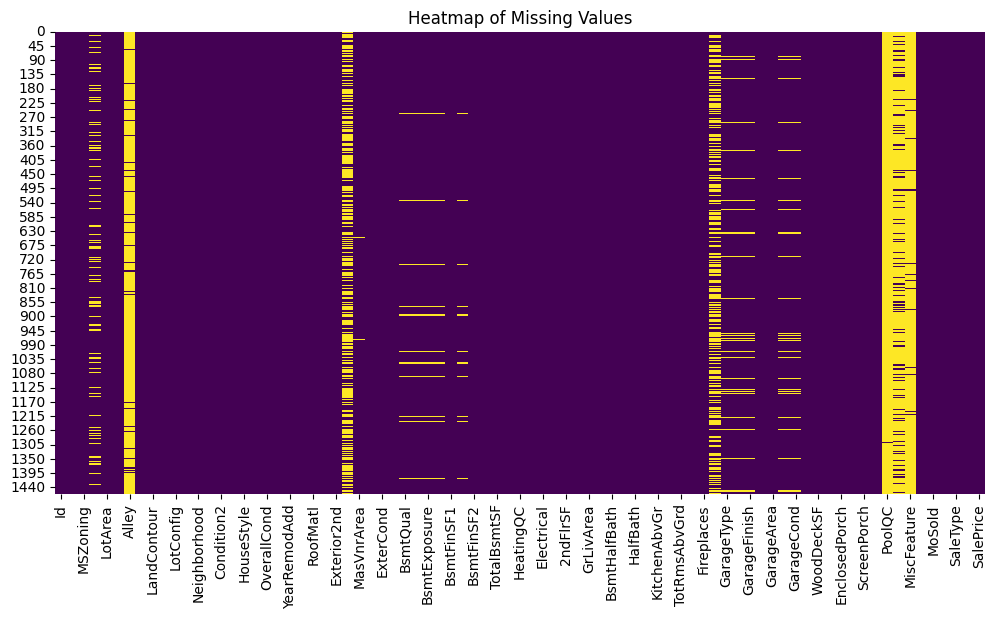

In [11]:
# Checking for missing values
missing_values = train_ds.isnull().sum().sort_values(ascending=False)
missing_percentage = (train_ds.isnull().sum() / train_ds.shape[0]).sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Visualizing missing data with a heatmap
# Just for reference. Don't make much sense due to number of features
plt.figure(figsize=(12, 6))
sns.heatmap(train_ds.isnull(), cmap='viridis', cbar=False)
plt.title('Heatmap of Missing Values')
plt.show()


In [12]:
missing_df.head(20)

,Missing Values,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


Dropping columns with missing values > 50%

In [13]:
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence','Id']
train_ds.drop(columns=columns_to_drop, axis=1, inplace=True)
test_ds.drop(columns=columns_to_drop, axis=1, inplace=True)


Columns with missing values between 5% and 50%

In [14]:
# Impute missing categorical values with mode
categorical_cols = ['MasVnrType', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                    'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for col in categorical_cols:
    train_ds[col].fillna(train_ds[col].mode()[0], inplace=True)
    test_ds[col].fillna(test_ds[col].mode()[0], inplace=True)

# Impute missing numerical values with median (to avoid influence of outliers)
numerical_cols = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for col in numerical_cols:
    train_ds[col].fillna(train_ds[col].median(), inplace=True)
    test_ds[col].fillna(test_ds[col].median(), inplace=True)



Columns with missing values < 5%

In [15]:
# Impute missing Electrical column with mode
train_ds['Electrical'].fillna(train_ds['Electrical'].mode()[0], inplace=True)
test_ds['Electrical'].fillna(test_ds['Electrical'].mode()[0], inplace=True)

Features related to the garage (GarageType, GarageCond, etc.) and basement (BsmtFinType1, BsmtCond, etc.) have multiple columns with the same number of missing values. This is likely because some houses don’t have a garage or basement.

In [16]:
# Impute missing Garage features
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_cols:
    train_ds[col].fillna('None', inplace=True)
    test_ds[col].fillna('None', inplace=True)

train_ds['GarageYrBlt'].fillna(0, inplace=True)
test_ds['GarageYrBlt'].fillna(0, inplace=True)

# Impute missing Basement features
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in bsmt_cols:
    train_ds[col].fillna('None', inplace=True)
    test_ds[col].fillna('None', inplace=True)


### Data visualization

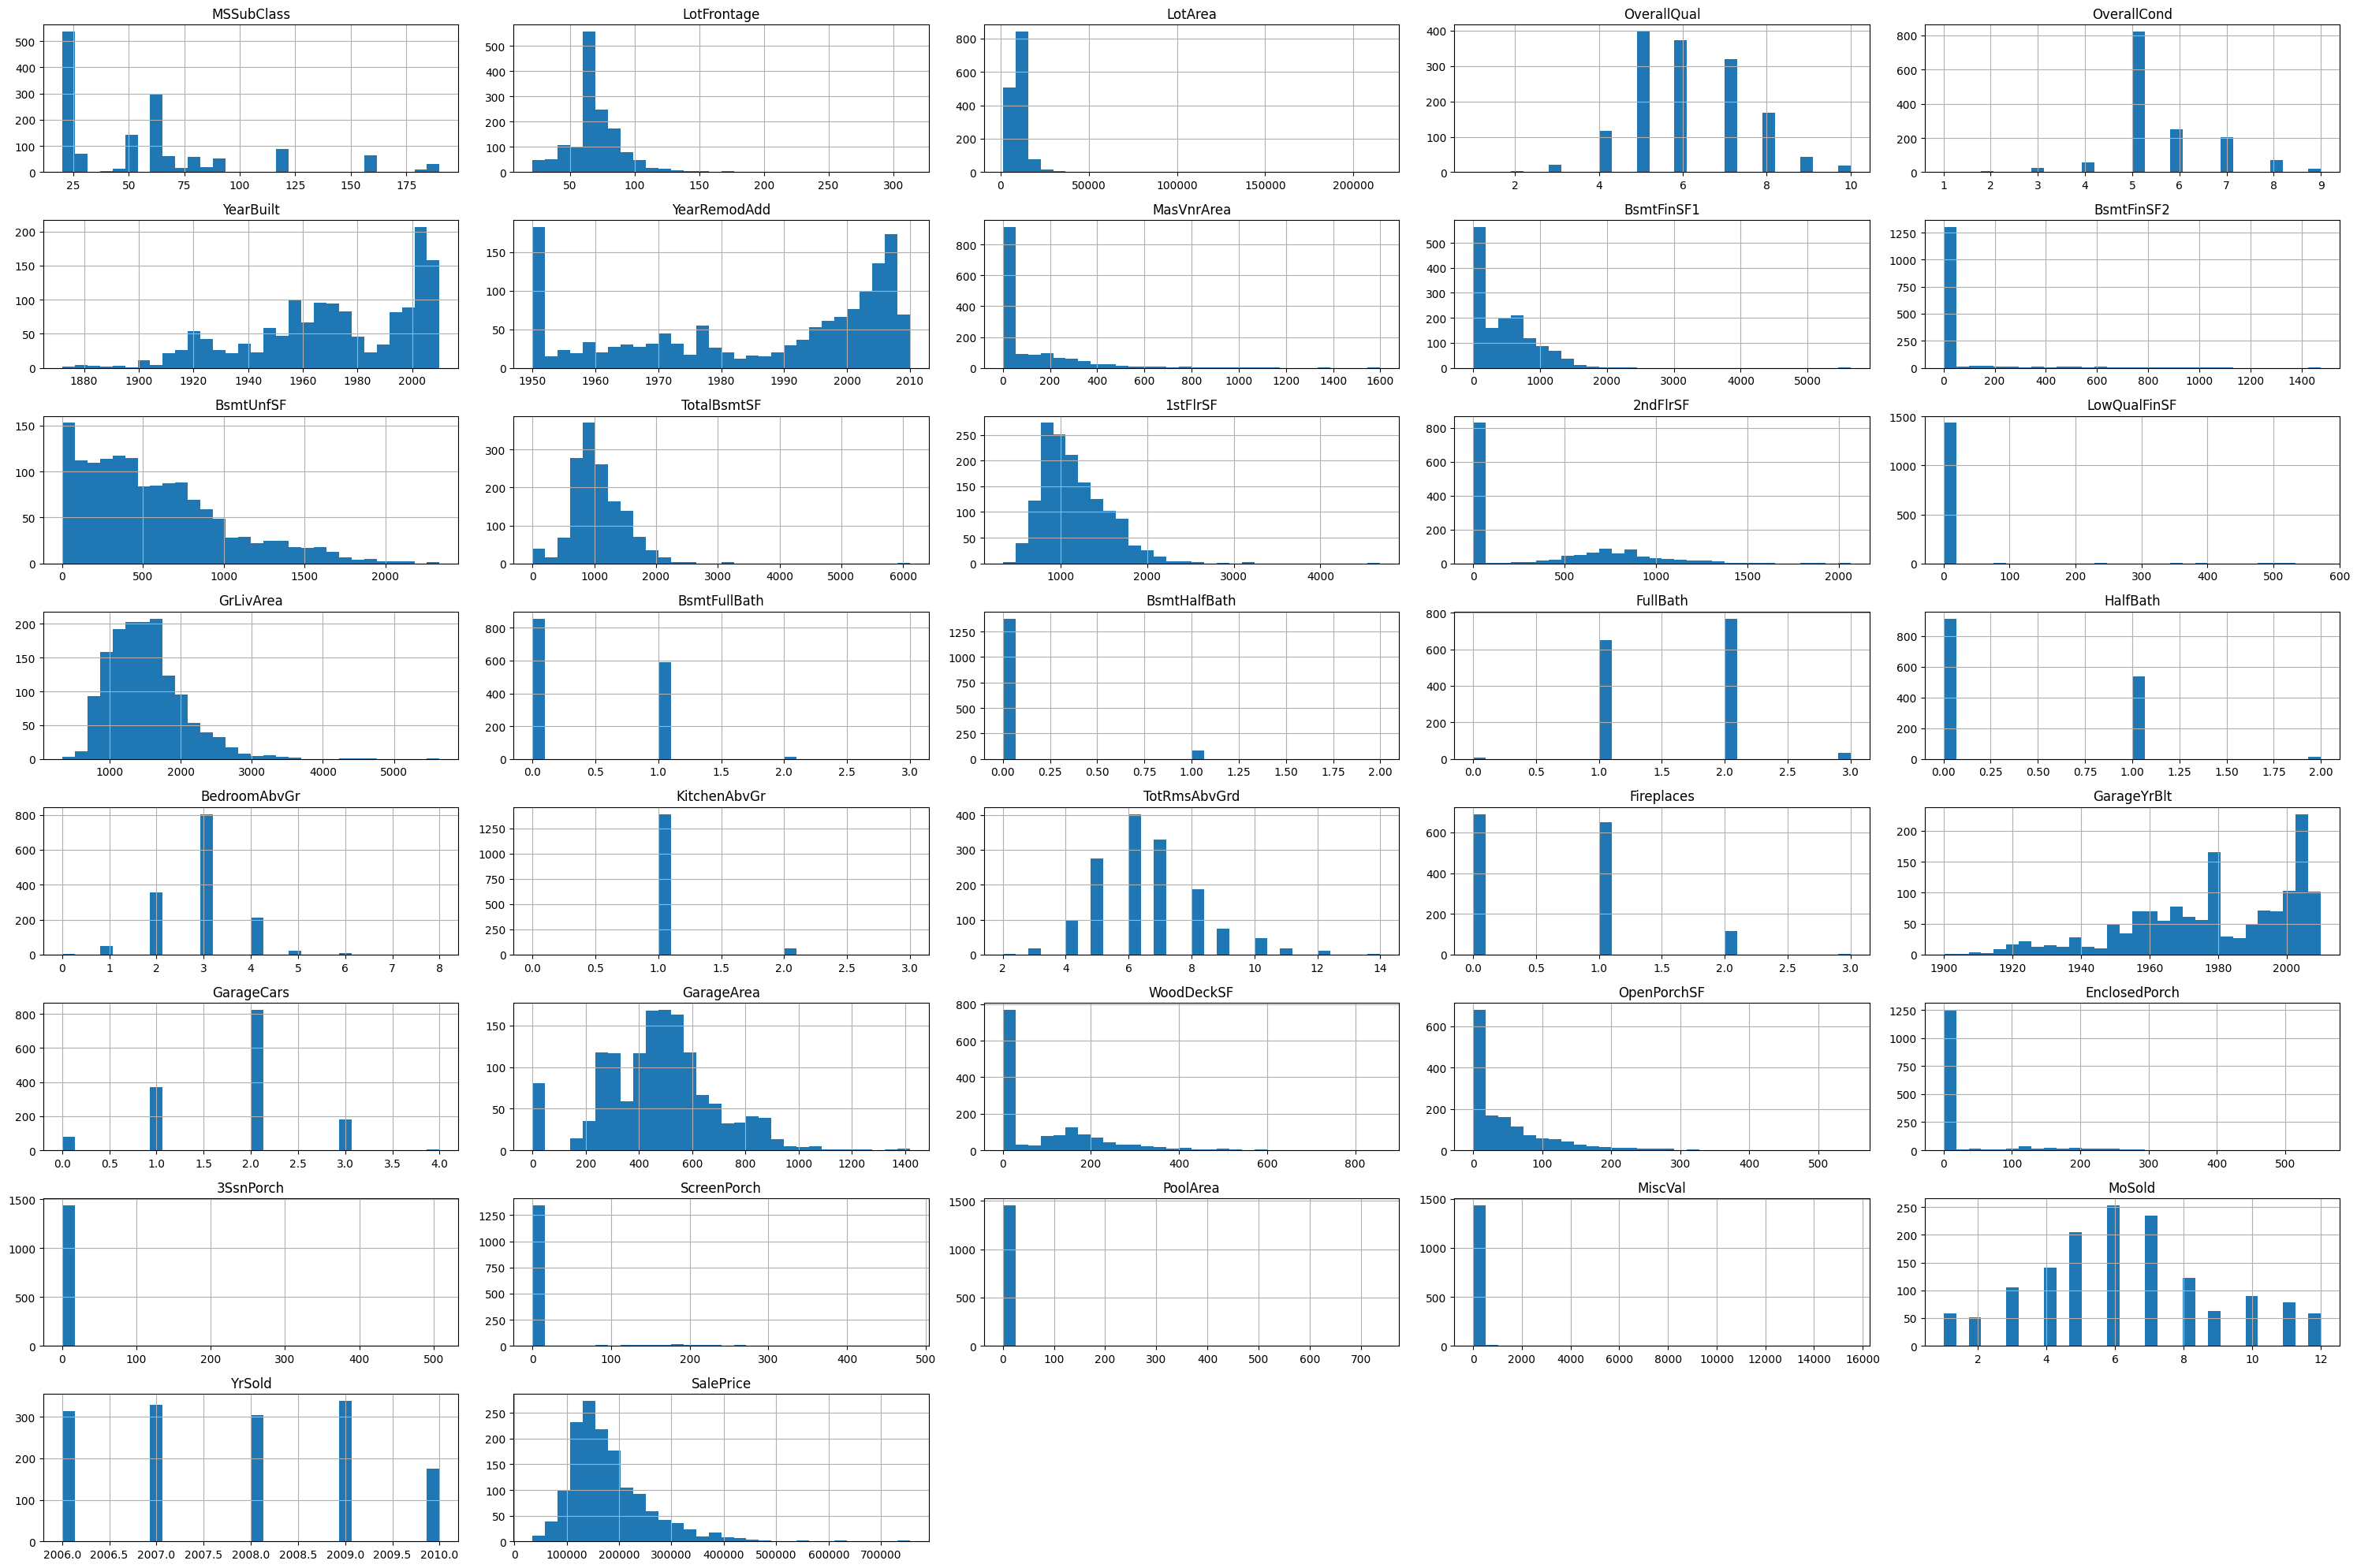

In [17]:
# Distribution of numeric features
import math

# Get all numeric columns
numeric_columns = train_ds.select_dtypes(include=['float64', 'int64']).columns

# Set up the grid layout (you can change rows and cols based on the number of features)
n_cols = 5  # Number of columns for the grid
n_rows = math.ceil(len(numeric_columns) / n_cols)  # Calculate required rows

# Create subplots with the determined grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 20))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes for easy iteration

# Plot each numeric column
for idx, col in enumerate(numeric_columns):
    train_ds[col].hist(bins=30, ax=axes[idx])
    axes[idx].set_title(col)

# Hide any empty subplots (if any)
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


The SalePrice variable in the last plot looks right skewed. Lets visualise the logarithm of the plot.

<Axes: >

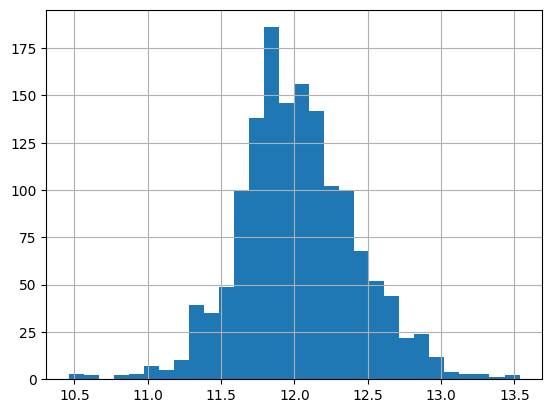

In [18]:
np.log1p(train_ds['SalePrice']).hist(bins=30)

The log plot looks more like a normally distributed value. We will try to train with log of outputs as training with normally distributed features geberally provide better results.

In [19]:
def preprocess_data(df):

  for i in df.columns:

    if df[i].dtype == 'object' or (df[i].dtype in ['int64'] and df[i].nunique() < 10): # Categorical Data
      df[i] = df[i].astype('category')
      df[i] = df[i].cat.codes
      df[i].fillna(df[i].mode()[0], inplace=True)

    elif df[i].dtype in ['int64', 'float64']:
      df[i].fillna(df[i].median(), inplace=True)
  return df


In [20]:
numeric_df = train_ds.copy()
numeric_df = preprocess_data(numeric_df)
corr_target = numeric_df.corr()['SalePrice'].sort_values(ascending=False)
print(corr_target.array)

<NumpyExtensionArray>
[                  1.0,    0.7909816005838053,    0.7086244776126515,
    0.6404091972583519,    0.6234314389183622,    0.6135805515591943,
    0.6058521846919153,    0.5606637627484453,    0.5337231555820284,
    0.5228973328794967,    0.5071009671113866,    0.4726144990045735,
   0.46692883675152763,    0.4667536523633407,    0.3864198062421535,
    0.3824789911901013,    0.3347708531397599,   0.32441344456812926,
   0.32297940082971094,   0.31933380283206736,   0.31585622711605504,
   0.28410767559478256,    0.2638433538714051,    0.2513281638401552,
   0.23494494099321922,   0.23135695225722747,   0.22712223313149427,
    0.2224052924071386,   0.21447910554696928,   0.21309202967780466,
   0.21085146582230307,   0.18016262334399108,   0.16881900146579923,
    0.1347400504670216,   0.13238311192778826,   0.11730265704316557,
   0.11532791708327839,   0.11144657114291112,    0.1037655370296585,
   0.10355101119090543,   0.09875850757327842,   0.09115491154092803

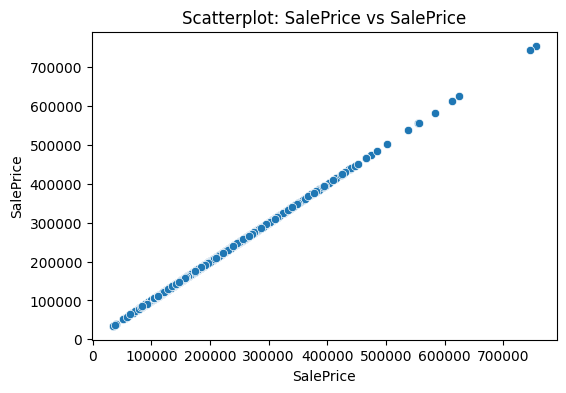

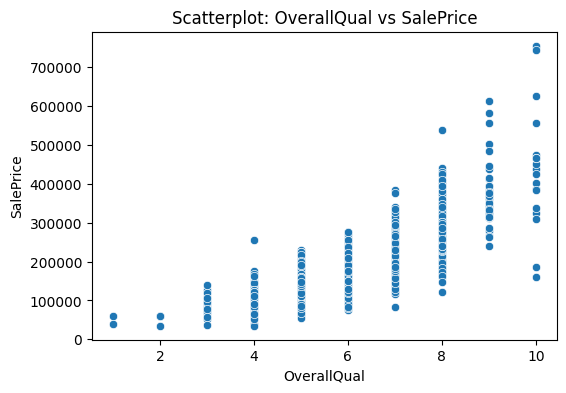

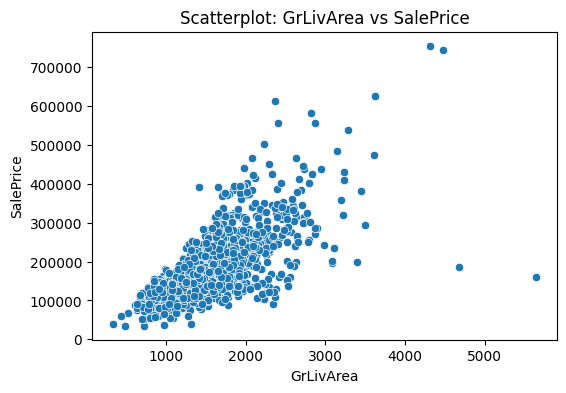

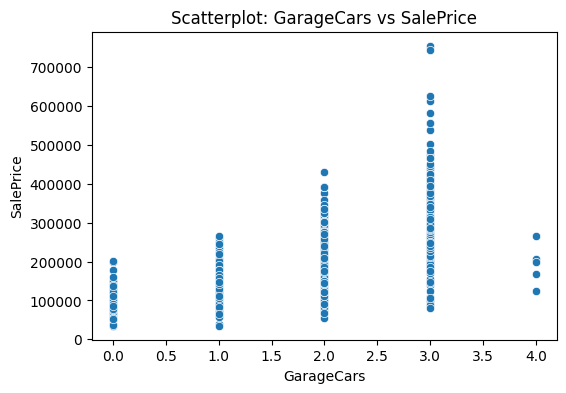

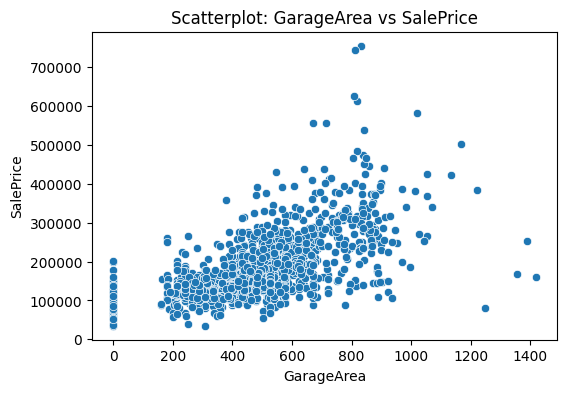

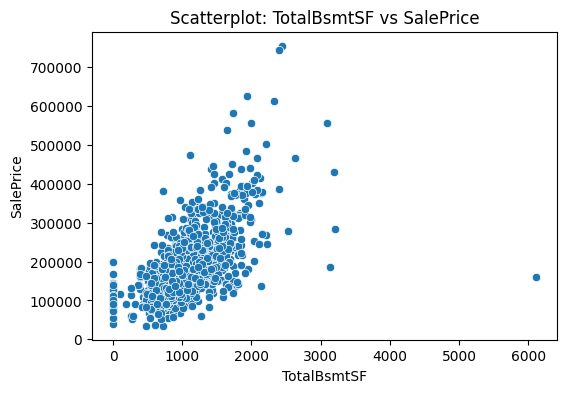

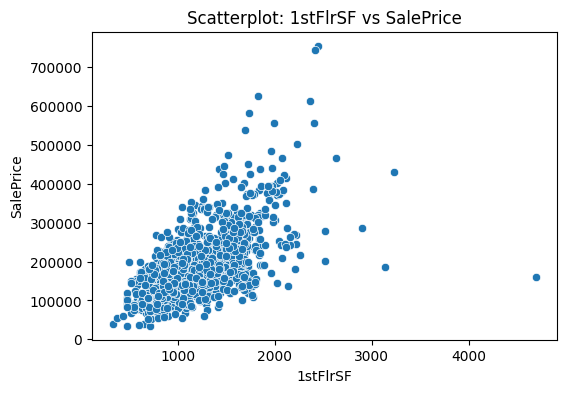

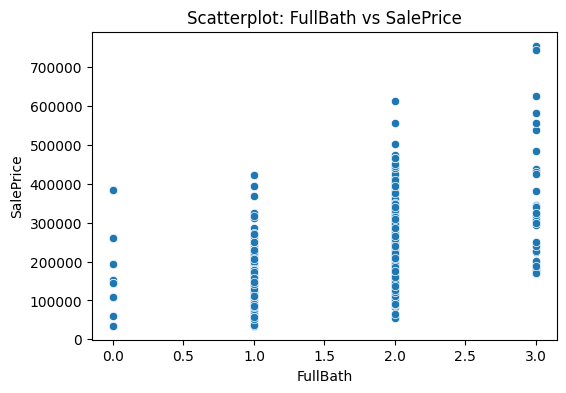

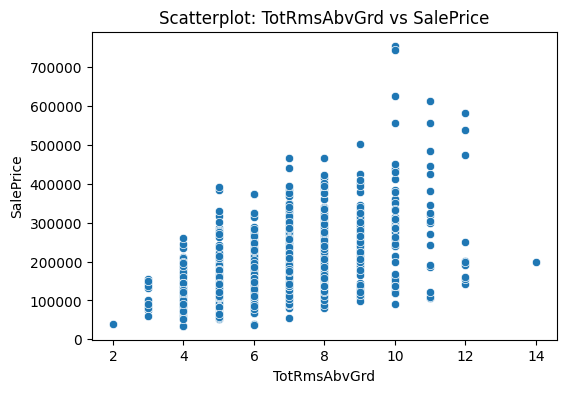

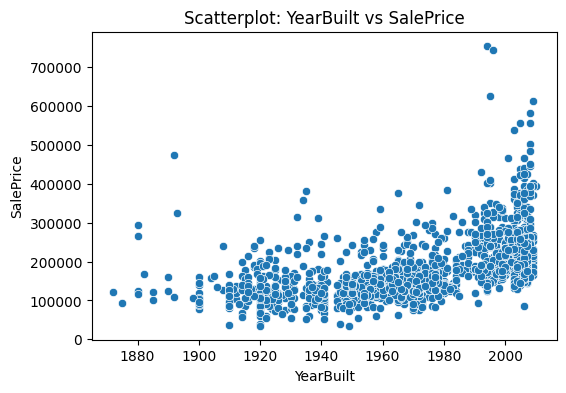

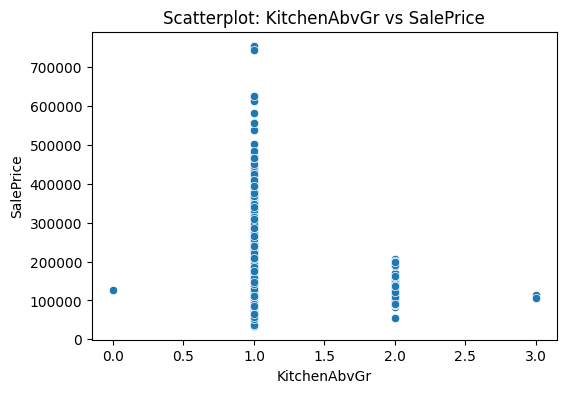

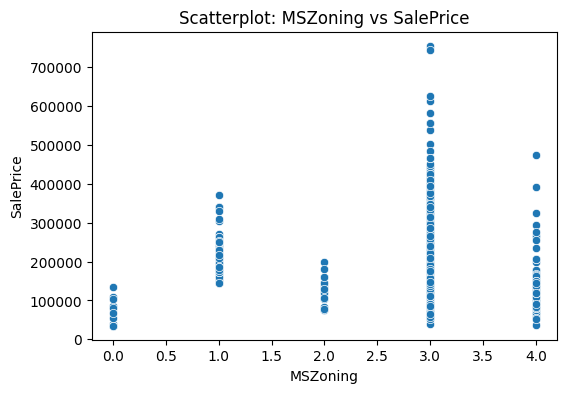

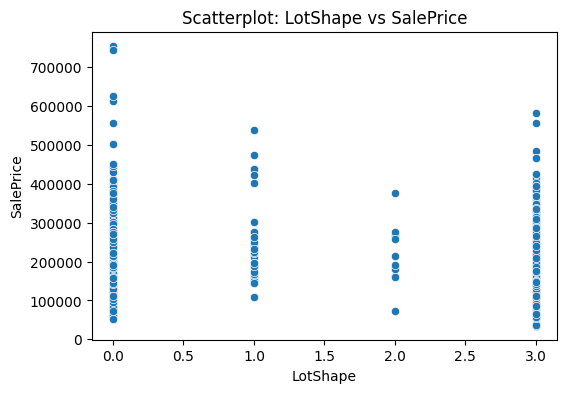

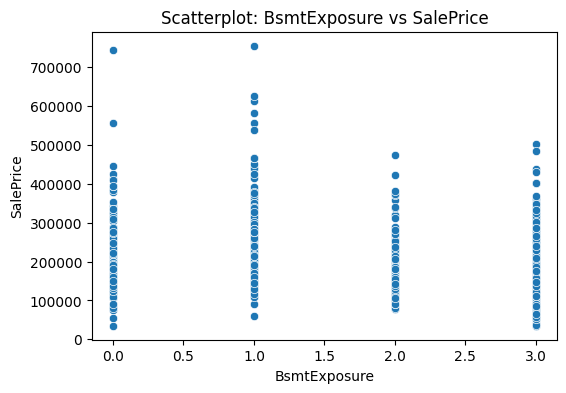

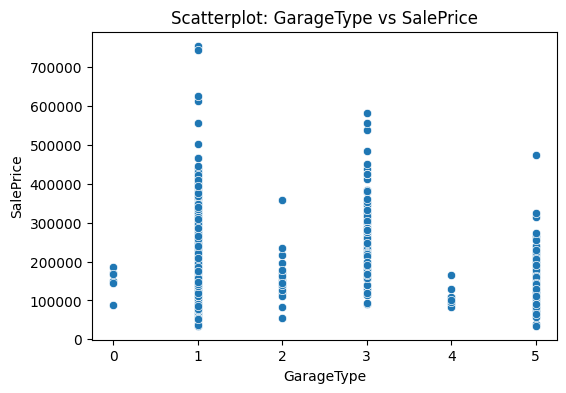

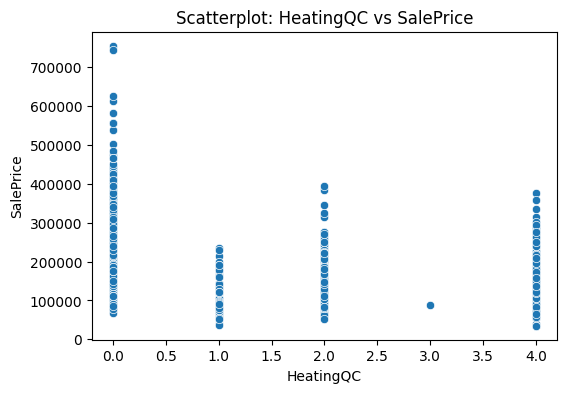

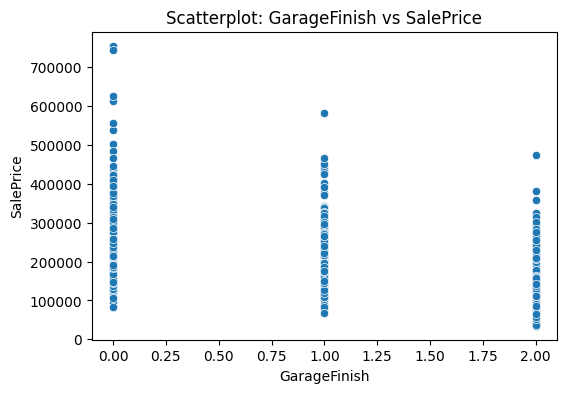

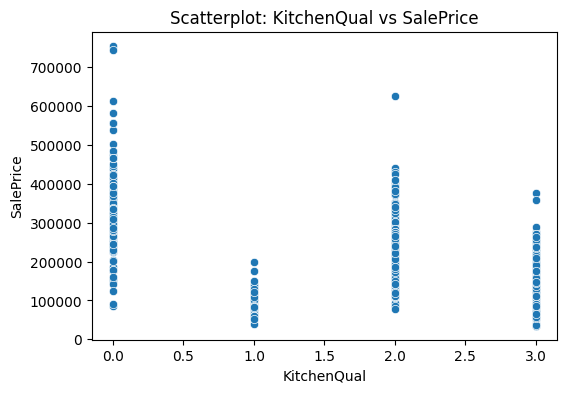

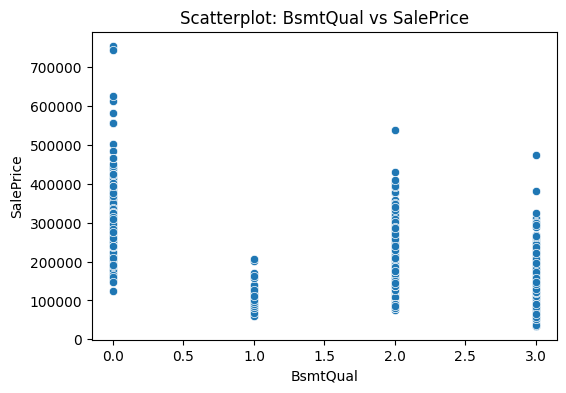

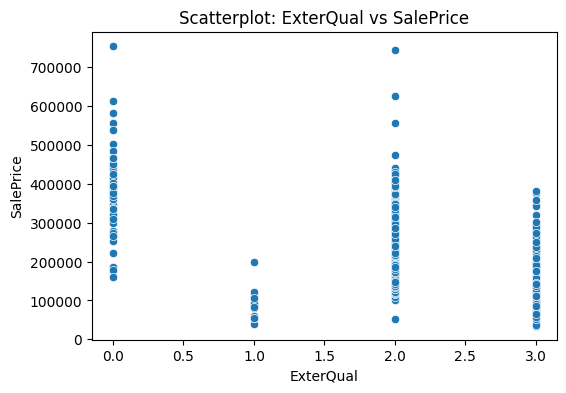

In [21]:
# Select top 10 positively and top 10 negatively correlated features for SalePrice
top_corr = corr_target.head(10).index.tolist()
low_corr = corr_target.tail(10).index.tolist()

# Visualize the correlation using scatterplots (for numerical variables)
for feature in top_corr:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=numeric_df[feature], y=numeric_df['SalePrice'])
    plt.title(f"Scatterplot: {feature} vs SalePrice")
    plt.show()

for feature in low_corr:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=numeric_df[feature], y=numeric_df['SalePrice'])
    plt.title(f"Scatterplot: {feature} vs SalePrice")
    plt.show()

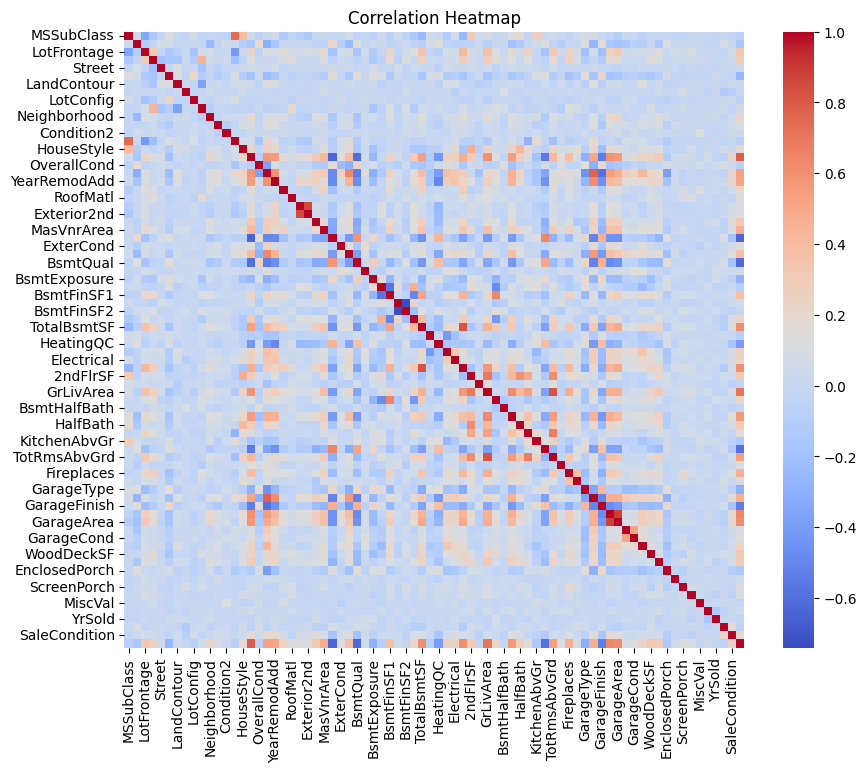

In [22]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


We can already see some highly correlated features. We will be dropping them to avoid performance impact due to multicollinearity.

### Preprocessing Data

Converting categorical data into numeric form and normalizing the numeric data for data consistency.

In [23]:
preprocess_data(train_ds)
preprocess_data(test_ds)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,3,3,0,4,0,...,0,0,0,120,0,0,6,4,8,4
1,20,3,81.0,14267,1,0,3,0,0,0,...,36,0,0,0,0,12500,6,4,8,4
2,60,3,74.0,13830,1,0,3,0,4,0,...,34,0,0,0,0,0,3,4,8,4
3,60,3,78.0,9978,1,0,3,0,4,0,...,36,0,0,0,0,0,6,4,8,4
4,120,3,43.0,5005,1,0,1,0,4,0,...,82,0,0,144,0,0,1,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,21.0,1936,1,3,3,0,4,0,...,0,0,0,0,0,0,6,0,8,4
1455,160,4,21.0,1894,1,3,3,0,4,0,...,24,0,0,0,0,0,4,0,8,0
1456,20,3,160.0,20000,1,3,3,0,4,0,...,0,0,0,0,0,0,9,0,8,0
1457,85,3,62.0,10441,1,3,3,0,4,0,...,32,0,0,0,0,700,7,0,8,4


In [24]:
xTrain = train_ds.iloc[:, :-1]
yTrain = train_ds.iloc[:, -1]

Correlation matrix for input features

In [25]:
correlation_matrix = xTrain.corr()

correlated_features = []
for i in range(len(correlation_matrix.columns)):
  for j in range(i + 1, len(correlation_matrix.columns)):  # Avoid duplicates and self-correlation
    if abs(correlation_matrix.iloc[i, j]) >= 0.7:
      correlated_features.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

correlated_features


[('MSSubClass', 'BldgType', 0.7460629359877902),
 ('YearBuilt', 'GarageYrBlt', 0.7771817647425319),
 ('Exterior1st', 'Exterior2nd', 0.8541629837325787),
 ('BsmtFinType2', 'BsmtFinSF2', -0.7399122539827684),
 ('TotalBsmtSF', '1stFlrSF', 0.8195299750050339),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8254893743088425),
 ('GarageCars', 'GarageArea', 0.882475414281462)]

We can drop one of the highly correlated features to avoid performance drop due to multicollinearity.

In [26]:
features_to_drop = [i[1] for i in correlated_features]
xTrain = xTrain.drop(columns=features_to_drop)
test_df = test_ds.drop(columns=features_to_drop)

## Model Training

In [27]:
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

We can define all the above steps in the pipeline. Implemented them separately for demonstration. Used "standardscaler" for features to have zero mean and unit variance.

In [28]:
model_linear = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', LinearRegression())
])

# Train the pipeline on the training data
model_linear.fit(xTrain, np.log1p(yTrain))

# Make predictions on the validation data
y_pred = model_linear.predict(xValid)

# Evaluate the model's performance (using RMSE here)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error((yValid), np.expm1(y_pred)))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 28177.194015230012


In [30]:
pipeline_rand_forest = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', RandomForestRegressor())
])

pipeline_rand_forest.fit(xTrain, yTrain)

# Make predictions on the validation data
y_pred_rand_forest = pipeline_rand_forest.predict(xValid)

# Evaluate the model's performance (using RMSE here)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(yValid, y_pred_rand_forest))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 28906.993771344554


Defining a custom tensorflow model within an sklearn compatible class

In [31]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

# Define a KerasRegressor with more advanced features
class KerasRegressor(BaseEstimator):
    def __init__(self, epochs=100, batch_size=32, learning_rate=0.001, dropout_rate=0.1):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(xTrain.shape[1],)))
        model.add(BatchNormalization())  # Batch normalization
        model.add(Dropout(self.dropout_rate))  # Dropout layer
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())  # Batch normalization
        model.add(Dropout(self.dropout_rate))  # Dropout layer
        model.add(Dense(1) )  # Output layer
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y):
        self.model = self.build_model()

        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Fit the model
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                       validation_split=0.2, callbacks=[early_stopping], verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Create a pipeline for the KerasRegressor
pipeline_tf = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', KerasRegressor(epochs=100, batch_size=16))  # You can adjust epochs and batch size here
])

# Fit the pipeline to the training data
pipeline_tf.fit(xTrain, log(yTrain))

# Make predictions on the validation data
y_pred_tf = pipeline_tf.predict(xValid)

# Evaluate the model's performance (using RMSE here)
rmse = np.sqrt(mean_squared_error(yValid, np.expm1(y_pred_tf)))
print(f'Root Mean Squared Error: {rmse}')



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Root Mean Squared Error: 34061.48820944179



I am not expecting to get a significant improvement with a deep learning model. Ensemble techniques using Random forest or xgBoost might provide even better results.

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg.fit(xTrain, yTrain)

# Make predictions
y_pred_xgb = xgb_reg.predict(xValid)

# Evaluate RMSE
rmse_xgb = np.sqrt(mean_squared_error(yValid, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 27664.523223953205


In [67]:
xgb_reg_grid = xgb.XGBRegressor(n_estimators=215,
                                learning_rate=0.057,
                           colsample_bytree=0.7,
                           max_depth=4,
                           reg_lambda=0.2,
                           subsample=0.6,
                           objective='reg:squarederror')

xgb_reg_grid.fit(xTrain, log(yTrain))

# Make predictions
y_pred_xgb = xgb_reg_grid.predict(xValid)

# Evaluate RMSE
rmse_xgb = np.sqrt(mean_squared_error(yValid, np.expm1(y_pred_xgb)))
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 24315.979604108743


##Hyperparameter Tuning and Model FineTuning

In [51]:
train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')


for i in train_ds:

    if train_ds[i].dtype == 'object' or (train_ds[i].dtype in ['int64'] and train_ds[i].nunique() < 10): # Categorical Data
      train_ds[i] = train_ds[i].astype('category')
      train_ds[i] = train_ds[i].cat.codes

for i in test_ds:

    if test_ds[i].dtype == 'object' or (test_ds[i].dtype in ['int64'] and test_ds[i].nunique() < 10): # Categorical Data
      test_ds[i] = test_ds[i].astype('category')
      test_ds[i] = test_ds[i].cat.codes
xTrain = train_ds.iloc[:, :-1]
xTrain.drop(columns=['Id'], inplace=True)
test_ds.drop(columns=['Id'], inplace=True)
yTrain = train_ds.iloc[:, -1]
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)


In [60]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb

# Define the base models with optimized parameters
base_models = [
    ('xgb', xgb.XGBRegressor(n_estimators=215, learning_rate=0.057, colsample_bytree=0.7, max_depth=4, reg_lambda=0.2, subsample=0.6, objective='reg:squarederror')),
    ('rf', RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=0.7, max_depth=10, random_state=42)),
]

# Meta-model with optimized parameters (Ridge regression)
meta_model = LinearRegression() #Ridge(alpha=10)

# Stacking Regressor with additional tree-based models
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacking model
stacking_model.fit(xTrain, log(yTrain))

# Make predictions and evaluate
y_pred_stack = stacking_model.predict(xValid)
rmse_stack = np.sqrt(mean_squared_error(yValid, np.expm1(y_pred_stack)))
print(f"Enhanced Stacking Model RMSE: {rmse_stack}")


Enhanced Stacking Model RMSE: 24036.77644565519


## Submission

In [68]:
test_pred_log = xgb_reg_grid.predict(test_ds)
result = np.expm1(test_pred_log)
result

array([125385.92, 153449.23, 175157.45, ..., 156162.86, 119576.39,
       224646.88], dtype=float32)

In [69]:
submission = pd.DataFrame({
    'Id': test['Id'],  # Replace with appropriate identifier
    'SalePrice': result # Replace with the predictions from the best model
})

In [70]:
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 21.1k/21.1k [00:00<00:00, 77.7kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

The final results I recieved on test data were 0.12913.
I will not try to improve this further as I will be tuning the model for the test dataset rather than crteating a generalised model.

Lessons Learned
1. Tree based models can perform better than Deep learning models in resource constrained regression problems.
2. Ensemble methods can perform better than individual methods.
3. Aggresive hyperparameter tuning can sometimes lead to overfitting.
4. Try simple and analyze the model to understand the problem.

Thanks for reading!!

Please share any feedbacks and comments.